In [1]:
%matplotlib notebook
import orbipy as op
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from copy import copy

In [2]:
model = op.crtbp3_model()
precise_model = op.crtbp3_model()
precise_model.integrator.set_params(max_step=np.pi/180)
stm_model = op.crtbp3_model(stm=True)

In [3]:
plotter = op.plotter.from_model(model, length_units='nd', velocity_units='nd/s')
scaler = plotter.scaler

In [4]:
class Hyperbolic:
    def __init__(self):
        self.c2 = self.calc_c2()
        self.lam = self.calc_lam()
        self.omega = self.calc_omega()
        self.k1 = self.calc_k1()
        self.k2 = self.calc_k2()
        self.k3 = self.calc_k3()
        self.k4 = self.calc_k4()
        
    def p1(self, state):
        (x, y) = state[:2]
        (vx, vy) = state[3:5]
        
        return ((self.k3*self.omega*x-self.k1*vy)/(self.k1*self.k4*self.lam+self.k2*self.k3*self.omega) +\
                (self.k1*self.omega*y+self.k3*vx)/(self.k2*self.k3*self.lam-self.k1*self.k4*self.omega))/2
    
    def p2(self, state):
        (x, y) = state[:2]
        x -= model.L1
        (vx, vy) = state[3:5]
        
        return ((self.k3*self.omega*x-self.k1*vy)/(self.k1*self.k4*self.lam+self.k2*self.k3*self.omega) -\
                (self.k1*self.omega*y+self.k3*vx)/(self.k2*self.k3*self.lam-self.k1*self.k4*self.omega))/2
    
    def calc_vy(self, state):
        (x, y) = state[:2]
        x -= model.L1
        (vx, vy) = state[3:5]
        
        return (self.k3*self.omega*x+(self.k1*self.k4*self.lam+self.k2*self.k3*self.omega)*(self.k1*self.omega*y+self.k3*vx)/(self.k2*self.k3*self.lam-self.k1*self.k4*self.omega))/self.k1
        
    def calc_c2(self):
        r1 = np.abs(model.L1+model.mu)
        r2 = np.abs(model.L1+model.mu-1)
        
        return (1.-model.mu)/r1**3+model.mu/r2**3
    
    def calc_lam(self):
        return np.sqrt((self.c2-2+np.sqrt(9*self.c2**2-8*self.c2))/2)
    
    def calc_omega(self):
        return np.sqrt((-1.*self.c2+2+np.sqrt(9*self.c2**2-8*self.c2))/2)
        
    def calc_k1(self):
        return -2/(self.c2+3+self.lam**2)
    
    def calc_k2(self):
        return -2/(2*self.c2+1-self.lam**2)
    
    def calc_k3(self):
        return (self.omega*(self.c2-1+self.lam**2))/((self.c2-1)*(self.c2+3+self.lam**2))
    
    def calc_k4(self):
        return (self.lam*(-2*self.c2+3+self.lam**2))/((self.c2-1)*(-2*self.c2-1+self.lam**2))

In [5]:
hyp = Hyperbolic()

In [6]:
large_orbs = pickle.load(open('../../OrbitsDiploma/large)orbs_examples','rb'))

In [26]:
EL1_dist = 1.-model.mu - model.L1
left = op.eventX(model.L1-EL1_dist)
right = op.eventX(1.-model.mu)

first_corr = op.border_correction(model, op.y_direction(), [left], [right])
corr = op.border_correction(model, op.x_direction(), [left], [right])
sk = op.simple_station_keeping(precise_model, first_corr, corr)

In [114]:
s0 = np.array([model.L1+scaler(100000,'km-nd'),0,scaler(250000,'km-nd'),0,0,0])
orb = sk.prop(0.0, s0, N=20)

Simple station-keeping: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


In [9]:
orb = large_orbs[-1]

<IPython.core.display.Javascript object>


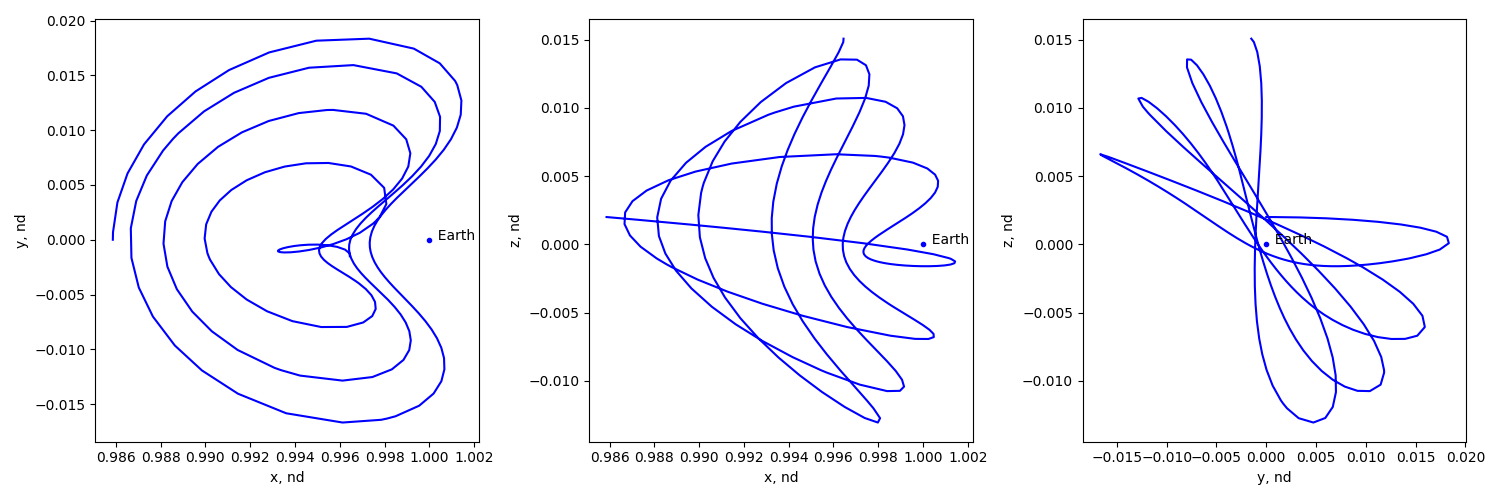

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7effd4cc0f28>,
      dtype=object)

In [10]:
ax = plotter.plot_proj(orb)
plotter.plot_proj(ax=ax, plottables=[plotter.m], marker='.')

In [11]:
ps = np.array([[hyp.p1(s[1:]), hyp.p2(s[1:])] for _, s in orb.iterrows()])

<IPython.core.display.Javascript object>


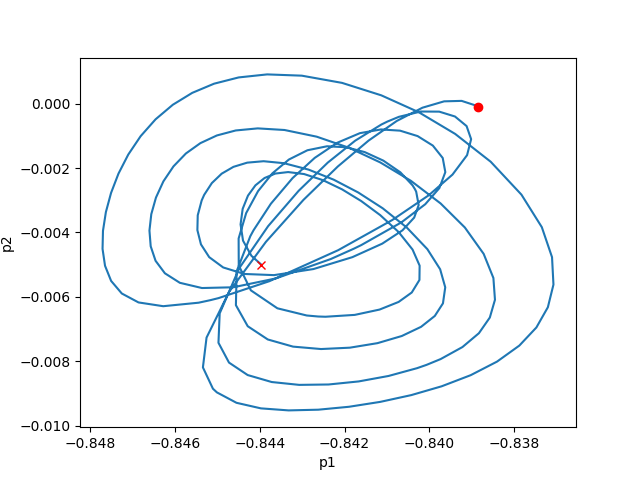

Text(0, 0.5, 'p2')

In [16]:
plt.plot(ps[:,0], ps[:,1])
plt.plot(ps[0,0], ps[0,1], 'ro')
plt.plot(ps[-1,0], ps[-1,1], 'rx')
plt.xlabel('p1')
plt.ylabel('p2')

In [18]:
class EventP1(op.base_event):
    def __call__(self, t, s):
        return hyp.p1(s) - self.value

In [50]:
# p1_left = EventP1(value=-0.838944, terminal=True)
# p1_right = EventP1(value=-0.83684, terminal=True)

p1_left = EventP1(value=-0.847981, terminal=True)
p1_right = EventP1(value=-0.83684, terminal=True)
# p1_left = EventP1(value=-0.848026, terminal=True)
# p1_right = EventP1(value=-0.836829, terminal=True)

In [51]:
events = [p1_left, p1_right]

In [56]:
def final_pos(s0, vy, events):
    s1 = s0.copy()
    s1[4] = vy
    detector = op.event_detector(model, events)
    df, ev = detector.prop(s1, 0., 100.)
    
    if ev.iloc[0]['e'] > 0.0:
        return 1
    else:
        return -1

In [53]:
dv = 1e-5 
vs = np.linspace(orb.iloc[0]['vy']-dv, orb.iloc[0]['vy']+dv, 100)

In [54]:
fps = [final_pos(orb.iloc[0][1:], v, events) for v in vs]

<IPython.core.display.Javascript object>


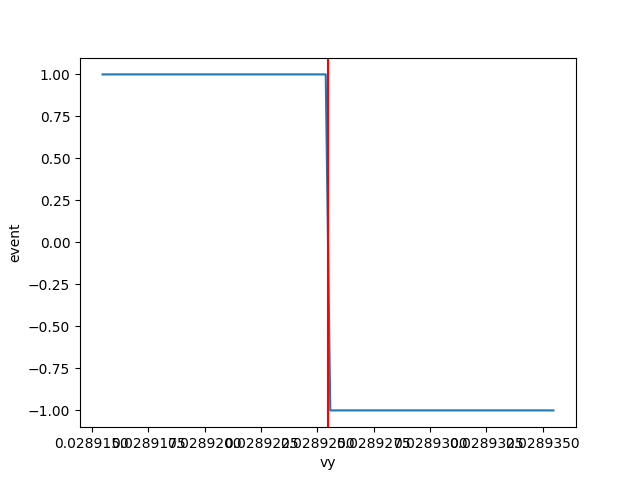

In [55]:
plt.plot(vs, fps)
plt.xlabel('vy')
plt.ylabel('event')
plt.axvline(orb.iloc[0]['vy'], color='r')

In [67]:
def generate_traj(s0, vs, in_p=True):
    trajectories = []
    
    for v in vs:
        s1 = s0.copy()
        s1[4] = v
        df = model.prop(s1, 0.0, 10*np.pi)
        if in_p:
            trajectories.append(np.array([[hyp.p1(s[1:]), hyp.p2(s[1:])] for _, s in df.iterrows()]))
        else:
            trajectories.append(df)
    
    return trajectories

In [68]:
trs_lower = generate_traj(orb.iloc[0][1:], vs[:50])
trs_upper = generate_traj(orb.iloc[0][1:], vs[51:])

<IPython.core.display.Javascript object>


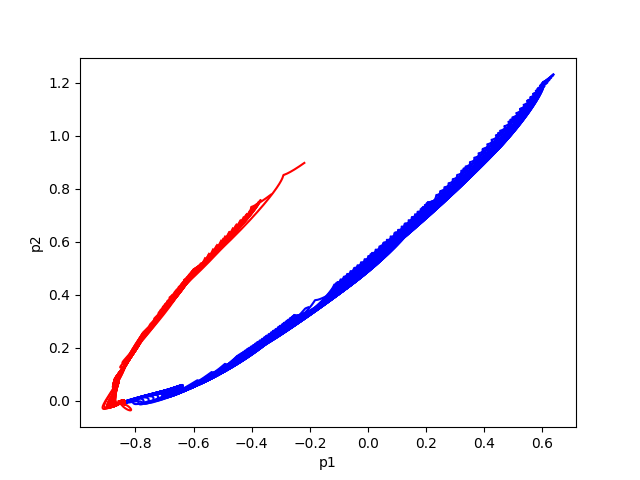

Text(0, 0.5, 'p2')

In [72]:
for tr in trs_lower:
    plt.plot(tr[:,0], tr[:,1], 'b')
for tr in trs_upper:
    plt.plot(tr[:,0], tr[:,1], 'r')
    
plt.xlabel('p1')
plt.ylabel('p2')